# Signal processing pipeline

In [5]:
from __future__ import division
def feature_eng(y, fs, vis=False):
    
    import librosa
    import librosa.display
    import numpy as np
    import maad
    from soundsig.sound import BioSound
    import matplotlib.pyplot as plt
    import pandas as pd
    import warnings
    warnings.simplefilter('ignore')
    
    # spectrum
    ps = np.abs(np.fft.fft(y))**2
    time_step = 1/fs
    freqs = np.fft.fftfreq(y.size, time_step)
    ps = ps[0:int((len(ps)/2)-1)] # take out the negative freq
    freqs = freqs[0:int((len(freqs)/2)-1)]

    # melspectrogram
    S = librosa.feature.melspectrogram(y=y, sr=fs)
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    # alpha indices
    Sxx_power,tn,fn,ext = maad.sound.spectrogram (y, fs, mode='psd')
    df_temporal_indices = maad.features.all_temporal_alpha_indices(y, fs)
    df_spectral_indices, _ = maad.features.all_spectral_alpha_indices(Sxx_power,tn,fn, extent=ext)
    df_indices = pd.concat([df_temporal_indices,df_spectral_indices], axis=1)
    
    # soundsig for modulation power spectrum
    
    myBioSound = BioSound(soundWave=y, fs=fs)
    myBioSound.mpsCalc(window=1, Norm = True)
    
    # reduce the dimension of MPS to one quadrant
    len1 = int(len(myBioSound.wf-1)/2)
    len2 = int(len(myBioSound.wt-1)/2)
    quad1 = myBioSound.mps[len1:,len2:]
    quad2 = np.fliplr(myBioSound.mps[len1:,:len2+1])
    mps = (quad1+quad2)/2
    wf = myBioSound.wf[len1:]
    wt = myBioSound.wt[len2:]
    
    if vis==True:
        plt.figure()
        plt.plot(np.arange(0,y.size/fs,1/fs), y)
        plt.show()
        
        fig, ax = plt.subplots()
        img = librosa.display.specshow(S_dB, x_axis='time',
                                 y_axis='mel', sr=fs,
                                 fmax=fs/2, ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title='Mel-frequency spectrogram')
        
        DBNOISE=100
        plt.figure()
        plt.clf()
        cmap = plt.get_cmap('jet')
        ex = (myBioSound.wt.min(), myBioSound.wt.max(), myBioSound.wf.min()*1e3, myBioSound.wf.max()*1e3)
        logMPS = 10.0*np.log10(myBioSound.mps)
        maxMPS = logMPS.max()
        minMPS = maxMPS-DBNOISE
        logMPS[logMPS < minMPS] = minMPS
        plt.imshow(logMPS, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
        plt.ylabel('Spectral Frequency (Cycles/KHz)')
        plt.xlabel('Temporal Frequency (Hz)')
        plt.colorbar()
        plt.ylim((0,myBioSound.wf.max()*1e3))
        plt.title('Modulation Power Spectrum')
        plt.show()
        
    
    return ps, freqs, S_dB, df_indices, mps, wt, wf
    

In [6]:
def preproc(file, fs=16000, vis=False):
    import librosa
    import numpy as np
    import matplotlib.pyplot as plt
    import noisereduce as nr
    
    raw_y, fs = librosa.load(file, sr=fs, duration=10, mono = True)
    y_mono_rs = raw_y - np.mean(raw_y) # remove DC
    rms = np.sqrt(np.mean(y_mono_rs**2)) # get rms
    y = y_mono_rs/(rms/0.1) # normalize the rms to 0.1
    
    fg_y = nr.reduce_noise(y=y, sr=fs)
    bg_y = y - fg_y
    
    
    if vis == True: print('++++++++++++++++++++++++ raw ++++++++++++++++++++++++')
    ps, freqs, S_dB, df_indices, mps, wt, wf = feature_eng(y, fs, vis)
    if vis == True: print('++++++++++++++++++++ foreground ++++++++++++++++++++')
    ps_fg, freqs_fg, S_dB_fg, df_indices_fg, mps_fg, wt_fg, wf_fg = feature_eng(fg_y, fs, vis)
    if vis == True: print('++++++++++++++++++++ background ++++++++++++++++++++')
    ps_bg, freqs_fg, S_dB_bg, df_indices_bg, mps_bg, wt_bg, wf_bg = feature_eng(bg_y, fs, vis)
    
    output = {'fs': fs, 'y': y, 'fg_y': fg_y, 'bg_y': bg_y,
             'df_indices': df_indices, 'mps': mps, 'wt': wt, 'wf': wf, 
             'df_indices_fg': df_indices_fg, 'mps_fg': mps_fg,
             'df_indices_bg': df_indices_bg, 'mps_bg': mps_bg}
    
    return output
    

In [7]:
# scan data directories

import glob
import pandas as pd
nature_file_list = []
nature_file_list += glob.glob('../data/raw/GoogleAudioSet_unbalanced_list/Outside, rural or natural/*')
nature_file_list += glob.glob('../data/raw/GoogleAudioSet_eval_list/Outside, rural or natural/*')

city_file_list = []
city_file_list += glob.glob('../data/raw/GoogleAudioSet_unbalanced_list/Outside, urban or manmade/*')
city_file_list += glob.glob('../data/raw/GoogleAudioSet_eval_list/Outside, urban or manmade/*')


remove_list_nature = glob.glob('../data/raw/GoogleAudioSet_unbalanced_list/Outside, rural or natural/AE0v7LesLZo*')
remove_list_city = glob.glob('../data/raw/GoogleAudioSet_unbalanced_list/Outside, urban or manmade/OPyovt30GPQ*')
remove_list_city += glob.glob('../data/raw/GoogleAudioSet_unbalanced_list/Outside, urban or manmade/CBmGYSOoeto*')


nature_file_list = [ele for ele in nature_file_list if ele not in remove_list_nature]
city_file_list = [ele for ele in city_file_list if ele not in remove_list_city]


++++++++++++++++++++++++ raw ++++++++++++++++++++++++


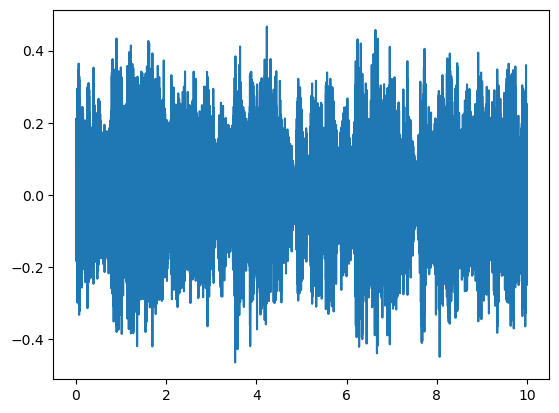

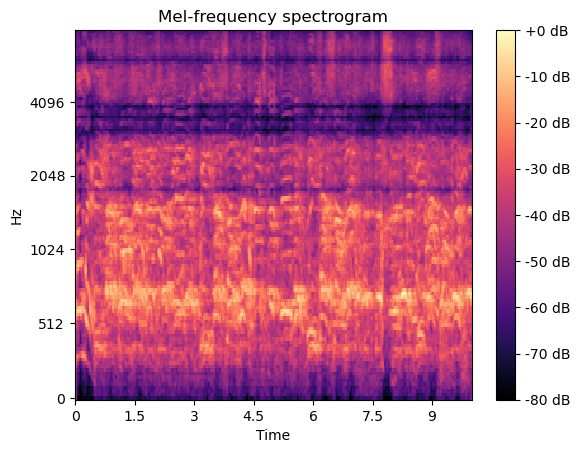

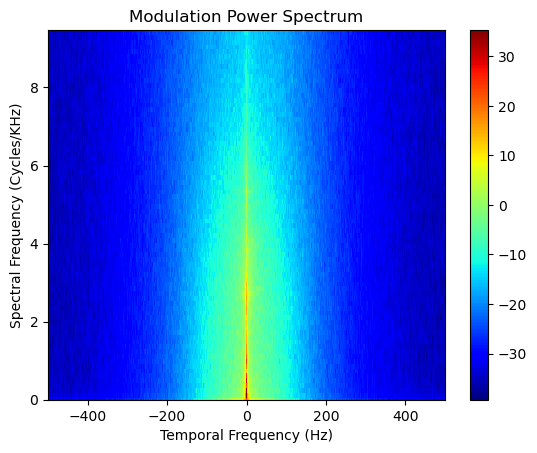

++++++++++++++++++++ foreground ++++++++++++++++++++


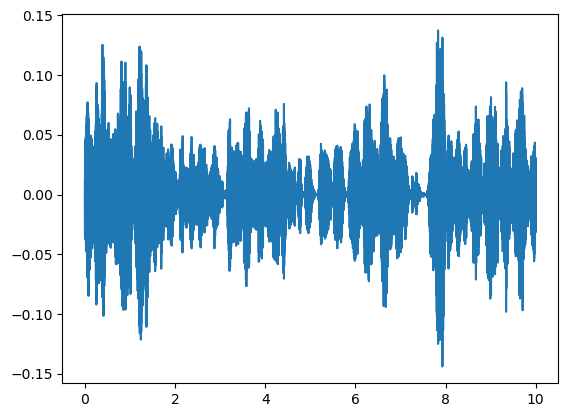

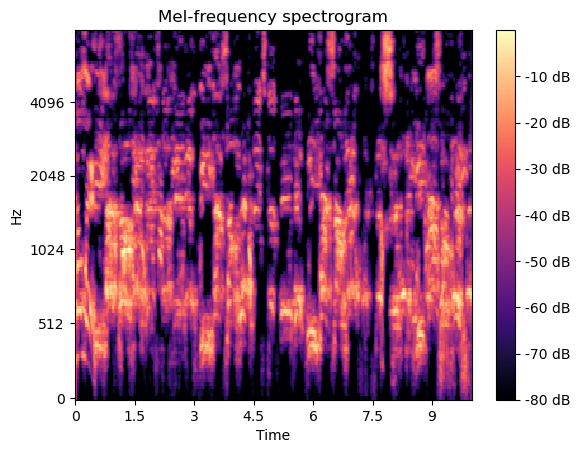

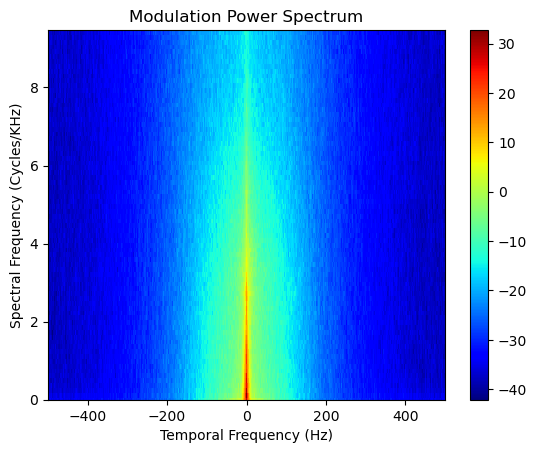

++++++++++++++++++++ background ++++++++++++++++++++


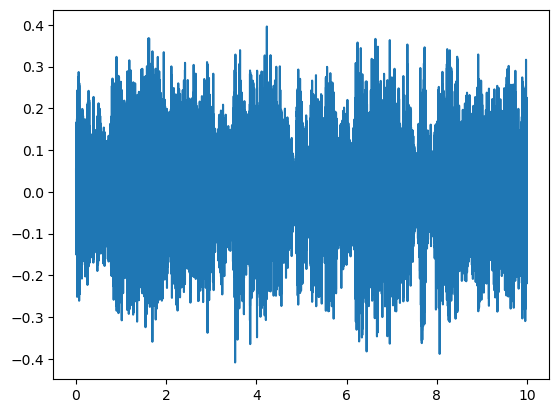

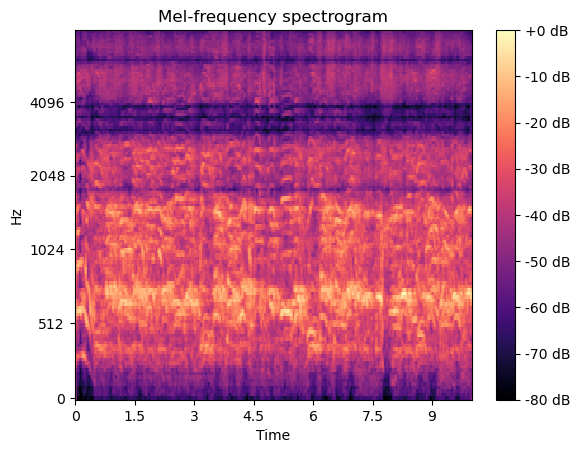

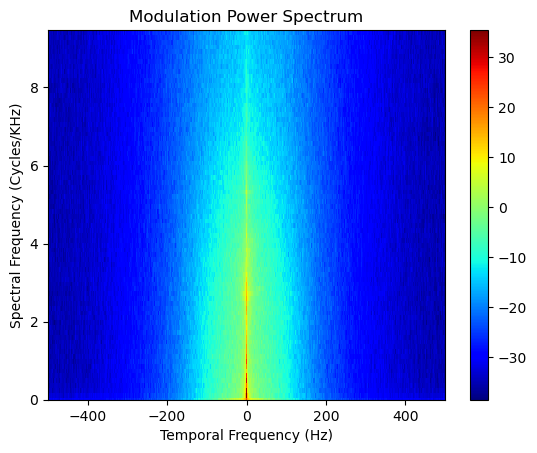

{'fs': 16000,
 'y': array([0.05441047, 0.03993597, 0.02812517, ..., 0.17358641, 0.162919  ,
        0.12269948], dtype=float32),
 'fg_y': array([ 0.00071142, -0.00017333, -0.00498011, ...,  0.01623001,
         0.01660063,  0.0112302 ], dtype=float32),
 'bg_y': array([0.05369905, 0.0401093 , 0.03310528, ..., 0.15735641, 0.14631836,
        0.11146928], dtype=float32),
 'df_indices':       ZCR         MEANt  VARt     SKEWt     KURTt       LEQt       BGNt  \
 0  2508.0 -5.986541e-10  0.01  0.013639  3.512462  73.020601 -10.823683   
 
        SNRt       MED        Ht  ...     TFSD  H_Havrda   H_Renyi  \
 0  0.222697  0.287618  0.977315  ...  0.49104  0.332964  3.402097   
 
    H_pairedShannon       H_gamma  H_GiniSimpson      RAOQ       AGI  ROItotal  \
 0         5.295599  15029.283125       0.974728  0.283913  1.703607         3   
 
    ROIcover  
 0  0.074106  
 
 [1 rows x 60 columns],
 'mps': array([[2.70527770e+02, 1.93555655e+02, 8.42645248e+01, ...,
         9.30984697e-04, 7.9

In [9]:
preproc(city_file_list[1], vis=True)

In [8]:
import time
import pickle
import os

from joblib import Parallel, delayed

def run_preproc(file_name):
    save_file_name = '../data/interim/'+file_name[12:-4]+'.pkl'
    if not os.path.isfile(save_file_name): # run the script only if the file does not exist
        if not os.path.exists(save_file_name.rsplit('/', 1)[0]): # create the folder if the folder does not exist
            os.makedirs(save_file_name.rsplit('/', 1)[0]) # extract the folder of the file path
            

        start_time = time.time()

        output = preproc(file_name, vis = False)
        f = open(save_file_name,'wb') # create a binary pickle file 
        pickle.dump(output,f)
        f.close()

        print("--- %s seconds ---" % (time.time() - start_time))
        

# run the process in parallel
Parallel(n_jobs=-1)(delayed(run_preproc)(file_name) for file_name in nature_file_list+city_file_list)

--- 14.265743732452393 seconds ---


/Users/andrewchang/opt/anaconda3/envs/AcousticEnv/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


--- 14.369647026062012 seconds ---
--- 14.451000213623047 seconds ---
--- 14.49503207206726 seconds ---
--- 14.510370969772339 seconds ---
--- 14.619852781295776 seconds ---
--- 14.754885196685791 seconds ---
--- 14.290563106536865 seconds ---
--- 6.0968849658966064 seconds ---
--- 10.689304113388062 seconds ---
--- 11.032370805740356 seconds ---
--- 10.98380422592163 seconds ---
--- 11.275682210922241 seconds ---
--- 11.210073947906494 seconds ---
--- 11.413533926010132 seconds ---
--- 11.659569263458252 seconds ---
--- 11.860825061798096 seconds ---
--- 11.639424085617065 seconds ---
--- 11.421092748641968 seconds ---
--- 11.119395017623901 seconds ---


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [9]:
# for file_name in nature_file_list+city_file_list:
#     print(file_name)
#     run_preproc(file_name)

--- 10.638025045394897 seconds ---
--- 7.1476452350616455 seconds ---
--- 7.347253084182739 seconds ---
--- 7.493006229400635 seconds ---
--- 11.045160055160522 seconds ---
--- 7.342309951782227 seconds ---
--- 6.762899160385132 seconds ---
--- 11.045053005218506 seconds ---
--- 7.458268165588379 seconds ---
--- 7.538299083709717 seconds ---
--- 6.87789511680603 seconds ---
--- 10.840168952941895 seconds ---
--- 10.743170976638794 seconds ---
--- 10.970125913619995 seconds ---
--- 7.046838045120239 seconds ---
--- 7.550773859024048 seconds ---
--- 7.4429991245269775 seconds ---
--- 6.322932958602905 seconds ---
--- 3.3854119777679443 seconds ---
